In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import requests

In [169]:
def fetch_data(tickers, start_date, end_date):
    if 'SPY' not in tickers:
        tickers.append('SPY')  # Add 'SPY' if not already there
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

In [170]:
def calculate_metrics(returns):
    """
    Calculates mean returns and the covariance matrix.
    """
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    return mean_returns, cov_matrix

In [171]:
def get_riskfree_rates():
    """
    Requests Risk Free Rates (US Treasury Yields) from alphavantage api
    """
    url = 'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=monthly&maturity=10year&apikey=RK5LVNJ5UAKB8NU7'
    r = requests.get(url)
    data = r.json()
    latest_rate = data['data'][0]['value']  # Get the latest rate
    return float(latest_rate) / 100  # Convert the rate to a float for further calculations


In [175]:
def monte_carlo_simulation(returns, mean_returns, cov_matrix, risk_free_rate, num_portfolios=5000): #number of simulations
    market_returns = returns['SPY']
    market_variance = market_returns.var() * 252
    
    low_risk_portfolio = None
    while low_risk_portfolio is None:
        results = np.zeros((4, num_portfolios))  # Return, Volatility, Sharpe Ratio, Beta
        weights_record = []

        for i in range(num_portfolios):
            weights = np.random.random(len(mean_returns) - 1)  # Generate weights
            weights /= np.sum(weights)  # Normalize weights to equal to 1
            weights_record.append(weights) 
            
            portfolio_return = np.dot(weights, mean_returns[:-1])
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.iloc[:-1, :-1], weights))) #Std Dev
            sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
            portfolio_returns = np.sum(weights * returns.iloc[:, :-1], axis=1)
            portfolio_covariance_with_market = np.cov(portfolio_returns, market_returns)[0, 1] * 252
            portfolio_beta = portfolio_covariance_with_market / market_variance
            results[:, i] = [portfolio_return, portfolio_volatility, sharpe_ratio, portfolio_beta]

        # Extract indices for specific portfolios
        min_beta_idx = np.argmin(results[3])
        if results[2, min_beta_idx] > 0:
            low_risk_portfolio = {
                'weights': weights_record[min_beta_idx],
                'return': results[0, min_beta_idx],
                'volatility': results[1, min_beta_idx],
                'sharpe_ratio': results[2, min_beta_idx],
                'beta': results[3, min_beta_idx],
                'index': min_beta_idx
            }

    # High Risk and Adequate Risk
    max_beta_idx = np.argmax(results[3])
    max_sharpe_idx = np.argmax(results[2])

    high_risk_portfolio = {
        'weights': weights_record[max_beta_idx],
        'return': results[0, max_beta_idx],
        'volatility': results[1, max_beta_idx],
        'sharpe_ratio': results[2, max_beta_idx],
        'beta': results[3, max_beta_idx],
        'index': max_beta_idx
    }
    adequate_risk_portfolio = {
        'weights': weights_record[max_sharpe_idx],
        'return': results[0, max_sharpe_idx],
        'volatility': results[1, max_sharpe_idx],
        'sharpe_ratio': results[2, max_sharpe_idx],
        'beta': results[3, max_sharpe_idx],
        'index': max_sharpe_idx
    }

    return results, low_risk_portfolio, high_risk_portfolio, adequate_risk_portfolio


In [176]:
def plot_simulation_results(results, special_indices):
    """
    Plots the results of the Monte Carlo simulation.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(results[1], results[0], c=results[2], cmap='viridis')
    special_colors = ['red', 'blue', 'green']  # Red for low risk, blue for high risk, green for adequate risk
    for i, color in zip(special_indices, special_colors):
        plt.scatter(results[1, i], results[0, i], c=color, s=50, edgecolors='black')
    plt.colorbar(label="Sharpe Ratio")
    plt.xlabel("Volatility")
    plt.ylabel("Return")
    plt.title("Portfolio Return vs. Volatility")
    plt.show()

Enter stock tickers (comma-separated): MSFT,TSLA,AAPL,NVDA,KO,XOM


[*********************100%%**********************]  7 of 7 completed


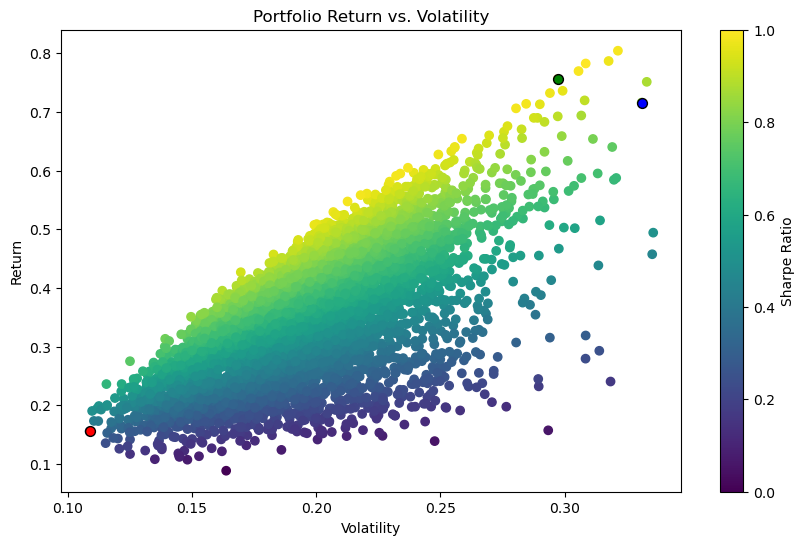


Low Risk Portfolio:
Weights: {'MSFT': 0.04463755273705206, 'TSLA': 0.3867516001338061, 'AAPL': 0.19862545406672952, 'NVDA': 0.0003016497375378772, 'KO': 0.3558868870211719, 'XOM': 0.013796856303702412}
Return: 0.15566695617082893
Volatility: 0.1088038582489303
Sharpe Ratio: 1.013447114334413
Beta: 0.8129402624654154

High Risk Portfolio:
Weights: {'MSFT': 0.09974075238098432, 'TSLA': 0.018123114378146694, 'AAPL': 0.03655817604594271, 'NVDA': 0.4910563899809769, 'KO': 0.0572873498570423, 'XOM': 0.297234217356907}
Return: 0.715689347186671
Volatility: 0.33098745324658563
Sharpe Ratio: 2.025120108366481
Beta: 1.9918450137720547

Adequate Risk Portfolio:
Weights: {'MSFT': 0.008042013377331778, 'TSLA': 0.18807977292333777, 'AAPL': 0.19477115154647312, 'NVDA': 0.5426585370878647, 'KO': 0.05889916986509426, 'XOM': 0.007549355199898382}
Return: 0.7557653535795638
Volatility: 0.2972573047118792
Sharpe Ratio: 2.3897322027732684
Beta: 1.69915150305763


In [177]:
def main():
    tickers = input("Enter stock tickers (comma-separated): ").split(',')
    tickers = list(dict.fromkeys(tickers))  # Remove any duplicate tickers
    start_date = datetime.now() - timedelta(days=365)
    end_date = datetime.now()

    returns = fetch_data(tickers, start_date, end_date)
    mean_returns, cov_matrix = calculate_metrics(returns)
    risk_free_rate = get_riskfree_rates()

    results, low_risk, high_risk, adequate_risk = monte_carlo_simulation(returns, mean_returns, cov_matrix, risk_free_rate)
    
    # Indices for special portfolios
    low_risk_idx = low_risk['index']
    high_risk_idx = high_risk['index']
    adequate_risk_idx = adequate_risk['index']

    plot_simulation_results(results, [low_risk_idx, high_risk_idx, adequate_risk_idx])

    # Display the portfolio details
    print("\nLow Risk Portfolio:")
    print("Weights:", dict(zip(tickers, low_risk['weights'])))
    print("Return:", low_risk['return'])
    print("Volatility:", low_risk['volatility'])
    print("Sharpe Ratio:", low_risk['sharpe_ratio'])
    print("Beta:", low_risk['beta'])

    print("\nHigh Risk Portfolio:")
    print("Weights:", dict(zip(tickers, high_risk['weights'])))
    print("Return:", high_risk['return'])
    print("Volatility:", high_risk['volatility'])
    print("Sharpe Ratio:", high_risk['sharpe_ratio'])
    print("Beta:", high_risk['beta'])

    print("\nAdequate Risk Portfolio:")
    print("Weights:", dict(zip(tickers, adequate_risk['weights'])))
    print("Return:", adequate_risk['return'])
    print("Volatility:", adequate_risk['volatility'])
    print("Sharpe Ratio:", adequate_risk['sharpe_ratio'])
    print("Beta:", adequate_risk['beta'])

if __name__ == "__main__":
    main()